In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import statsmodels.formula.api as smf
from econml.dml import LinearDML
from matplotlib import pyplot as plt

In [3]:
# Парадокс Симпсона

In [32]:
# Мы немного хитрим -исходных данных мало для статзначимости, возьмем в 10 раз больше для иллюстрации
# Можно было бы работать и с исходной выборкой - но мы вернемся к ней потом
tmp = (
    [{"stone": "small", "threatment": "A", "result": 1}] * 810 + 
    [{"stone": "small", "threatment": "A", "result": 0}] * 60 + 
    [{"stone": "large", "threatment": "A", "result": 1}] * 1920 + 
    [{"stone": "large", "threatment": "A", "result": 0}] * 710 + 
    [{"stone": "small", "threatment": "B", "result": 1}] * 2340 + 
    [{"stone": "small", "threatment": "B", "result": 0}] * 360 + 
    [{"stone": "large", "threatment": "B", "result": 1}] * 550 + 
    [{"stone": "large", "threatment": "B", "result": 0}] * 250 
)


df_kidney = pd.DataFrame(tmp).sample(frac=1)
df_kidney.head()

stone threatment  result
6986  large          B       0
5444  small          B       1
5082  small          B       1
1740  large          A       1
3748  small          B       1

In [5]:
df_kidney.pivot_table(columns="threatment", index="stone", values="result", aggfunc="mean")

threatment         A         B
stone                         
large       0.730038  0.687500
small       0.931034  0.866667

In [6]:
smf.ols("result ~ threatment", df_kidney).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.18
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.51e-06
Time:                        00:17:37   Log-Likelihood:                -3469.1
No. Observations:                7000   AIC:                             6942.
Df Residuals:                    6998   BIC:                             6956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7800      0.007    116.165      0.000       0.767       0.793
threatment[T.B]     0.0457      0.009      4.814      0.000       0.027       0.064
==============================================================================
Omnibus:                     1502.032   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2706.577
Skew:                          -1.515   Prob(JB):                         0.00
Kurtosis:                       3.316   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Обратите внимание на маленький R2
smf.ols("result ~ threatment + stone", df_kidney).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     164.4
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.69e-70
Time:                        00:17:37   Log-Likelihood:                -3319.9
No. Observations:                7000   AIC:                             6646.
Df Residuals:                    6997   BIC:                             6666.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7327      0.007    103.036      0.000       0.719       0.747
threatment[T.B]    -0.0538      0.011     -4.936      0.000      -0.075      -0.032
stone[T.small]      0.1904      0.011     17.453      0.000       0.169       0.212
==============================================================================
Omnibus:                     1366.390   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2344.244
Skew:                          -1.411   Prob(JB):                         0.00
Kurtosis:                       3.270   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Сначала сгенерируем искусственные данные об эпидемии заболевания Ковид-3000
Хворь напала на два города, заболел 1% населения.

Города по-разному обеспечены ИВЛ, поэтому в маленьком городе их применяют в более легких случаях.

Нужно понять, как ИВЛ влияет на выживаемость пациентов

In [8]:
np.random.seed(20250823)

In [9]:
cities = [
    {"city": "Б", "population": 101987, "threshold_vent": 0.4, },
    {"city": "Н", "population": 1637266, "threshold_vent": 0.6, }, #Дисбаланс
]
POPULATION = sum(x["population"] for x in cities)
R = 0.01
severity_a = 1
severity_b = 4
severity_threshold = 0.35
UPLIFT_VENT = 0.5
UPLIFT_BASE = 0.9
N = int(POPULATION * R)
AGE_DEBAFF = 0.01

In [10]:
df_cities = pd.DataFrame(cities).set_index("city")
df_cities

population  threshold_vent
city                            
Б         101987             0.4
Н        1637266             0.6

Для каждого заболевшего предскажем его судьбу

Поскольку данные синтетические, добавим так же столбцы с контрфактическими исходами - если бы ИВЛ подключили и если бы ИВЛ не подключили. В реальности этих данных быть не может.

In [11]:
df_cf = (
    pd.DataFrame({
        "city": np.random.choice([x["city"] for x in cities], size=N, replace=True, p=[x["population"]/POPULATION for x in cities]),
        "severity": np.random.beta(severity_a, severity_b, N),
        "sex": np.random.choice([1, 0],p=[0.6, 0.4],size=N),
        "age": np.random.randint(0, 100, N),
    })
    .join(df_cities, on="city")
    .assign(severe = lambda x: x.severity >= severity_threshold, vent = lambda x: x.severity >= x.threshold_vent, city=lambda x: pd.Categorical(x.city))
    .assign(treatment_result = lambda x: (x.severity - x.severity*x.vent.astype(int)*UPLIFT_VENT)*UPLIFT_BASE)
    .assign(cft0 = lambda x: (x.severity * UPLIFT_BASE))
    .assign(cft1 = lambda x: (x.severity - x.severity*UPLIFT_VENT)*UPLIFT_BASE)
    .assign(fate = lambda x: np.random.rand(N) - np.log1p(x.age)*AGE_DEBAFF)
    .assign(outcome = lambda x: (x.treatment_result < x.fate).astype(int), outcome0 = lambda x: (x.cft0 < x.fate).astype(int), outcome1 = lambda x: (x.cft1 < x.fate).astype(int))
).assign(city=lambda x: pd.Categorical(x.city).codes)
df_cf.head(10)


city  severity  sex  age  population  threshold_vent  severe   vent  \
0     1  0.004053    1   45     1637266             0.6   False  False   
1     1  0.273414    1   43     1637266             0.6   False  False   
2     1  0.471883    1   94     1637266             0.6    True  False   
3     1  0.059702    1   12     1637266             0.6   False  False   
4     1  0.075537    0   77     1637266             0.6   False  False   
5     1  0.205658    1   63     1637266             0.6   False  False   
6     1  0.284580    1   74     1637266             0.6   False  False   
7     1  0.311626    0   61     1637266             0.6   False  False   
8     1  0.495795    1   37     1637266             0.6    True  False   
9     1  0.298261    0   21     1637266             0.6   False  False   

   treatment_result      cft0      cft1      fate  outcome  outcome0  outcome1  
0          0.003648  0.003648  0.001824  0.212537        1         1         1  
1          0.246073  0.246073  0.123036  0.258300        1         1         1  
2          0.424695  0.424695  0.212348  0.309609        0         0         1  
3          0.053732  0.053732  0.026866  0.357192        1         1         1  
4          0.067983  0.067983  0.033992  0.909910        1         1         1  
5          0.185093  0.185093  0.092546  0.932234        1         1         1  
6          0.256122  0.256122  0.128061  0.775496        1         1         1  
7          0.280463  0.280463  0.140232  0.843378        1         1         1  
8          0.446215  0.446215  0.223108  0.165681        0         0         0  
9          0.268435  0.268435  0.134218  0.538928        1         1         1

In [12]:
print(f"""
В среднем выжило {df_cf.outcome.mean():.1%} заболевших
Кажущийся эффект от ИВЛ: {df_cf[lambda x: x.vent==True].outcome.mean() - df_cf[lambda x: x.vent==False].outcome.mean():.1%}

Выжило после ИВЛ: {df_cf[lambda x: x.vent==True].outcome.mean():.1%}
Сколько выжило бы без ИВЛ из тех, кому его назначили: {df_cf[lambda x: x.vent==True].outcome0.mean():.1%}
ATE Реальный эффект от ИВЛ: {df_cf[lambda x: x.vent==True].outcome.mean() - df_cf[lambda x: x.vent==True].outcome0.mean():.1%}

Выжило без ИВЛ: {df_cf[lambda x: x.vent==False].outcome.mean():.1%}
Сколько выжило бы с ИВЛ из тех, кому его не дали: {df_cf[lambda x: x.vent==False].outcome1.mean():.1%}
Возможный эффект от ИВЛ: {df_cf[lambda x: x.vent==False].outcome1.mean() - df_cf[lambda x: x.vent==False].outcome.mean():.1%}

Средний возможный эффект по популяции {df_cf.outcome1.mean() - df_cf.outcome0.mean():.1%}
""")


В среднем выжило 79.6%
Кажущийся эффект от ИВЛ: -11.4%

Выжило после ИВЛ: 68.5%
Сколько выжило бы без ИВЛ из тех, кому его назначили: 40.4%
ATE Реальный эффект от ИВЛ: 28.1%

Выжило без ИВЛ: 79.9%
Сколько выжило бы с ИВЛ из тех, кому его не дали: 88.5%
Возможный эффект от ИВЛ: 8.6%

Средний ожидаемый эффект по популяции 9.2%



In [13]:
df_cf.to_parquet("df_cf.pq")
df_cf[['city', 'severe', 'vent', 'outcome', 'sex', 'age']].to_parquet("df_a.pq")
df_cf[['city', 'severity', 'vent', 'outcome', 'sex', 'age']].to_parquet("df_b.pq")

In [33]:
df = pd.read_parquet("df_a.pq")

In [34]:
df.head()

city  severe   vent  outcome  sex  age
0     1   False  False        1    1   45
1     1   False  False        1    1   43
2     1    True  False        0    1   94
3     1   False  False        1    1   12
4     1   False  False        1    0   77

In [35]:
# Оценим кажущийся эффект от ИВЛ
model = smf.ols("outcome ~ vent", df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     44.13
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           3.16e-11
Time:                        00:40:16   Log-Likelihood:                -8857.8
No. Observations:               17392   AIC:                         1.772e+04
Df Residuals:                   17390   BIC:                         1.774e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7994      0.003    257.492      0.000       0.793       0.806
vent[T.True]    -0.1140      0.017     -6.643      0.000      -0.148      -0.080
==============================================================================
Omnibus:                     3522.375   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6218.835
Skew:                          -1.463   Prob(JB):                         0.00
Kurtosis:                       3.156   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
model = smf.ols("outcome ~ vent + severe + age", df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     325.0
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          2.50e-205
Time:                        00:40:17   Log-Likelihood:                -8405.4
No. Observations:               17392   AIC:                         1.682e+04
Df Residuals:                   17388   BIC:                         1.685e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8587      0.006    141.352      0.000       0.847       0.871
vent[T.True]       0.1021      0.018      5.614      0.000       0.066       0.138
severe[T.True]    -0.2544      0.008    -30.197      0.000      -0.271      -0.238
age               -0.0004      0.000     -4.017      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     3308.804   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5613.077
Skew:                          -1.384   Prob(JB):                         0.00
Kurtosis:                       3.291   Cond. No.                         358.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model_t = smf.ols("vent ~  severe + city", df.assign(vent = lambda x: x.vent.astype(int))).fit()
model_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vent   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     1811.
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:40:18   Log-Likelihood:                 6995.8
No. Observations:               17392   AIC:                        -1.399e+04
Df Residuals:                   17389   BIC:                        -1.396e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0963      0.005     18.804      0.000       0.086       0.106
severe[T.True]     0.1815      0.003     56.778      0.000       0.175       0.188
city              -0.1021      0.005    -19.499      0.000      -0.112      -0.092
==============================================================================
Omnibus:                    13659.906   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254651.794
Skew:                           3.783   Prob(JB):                         0.00
Kurtosis:                      20.152   Cond. No.                         8.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
model_y = smf.ols("outcome ~ severe + age", df.assign(vent = lambda x: x.vent.astype(int))).fit()
model_y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     470.9
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          6.88e-200
Time:                        00:40:20   Log-Likelihood:                -8421.2
No. Observations:               17392   AIC:                         1.685e+04
Df Residuals:                   17389   BIC:                         1.687e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8585      0.006    141.207      0.000       0.847       0.870
severe[T.True]    -0.2358      0.008    -30.412      0.000      -0.251      -0.221
age               -0.0004      0.000     -3.988      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     3303.730   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5604.495
Skew:                          -1.384   Prob(JB):                         0.00
Kurtosis:                       3.277   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
model = smf.ols("r_outcome ~ r_vent-1", df.assign(r_vent = model_t.resid, r_outcome = model_y.resid)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              r_outcome   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              27.90
Date:                Sun, 28 Sep 2025   Prob (F-statistic):                    1.29e-07
Time:                        00:40:31   Log-Likelihood:                         -8407.2
No. Observations:               17392   AIC:                                  1.682e+04
Df Residuals:                   17391   BIC:                                  1.682e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
r_vent         0.0971      0.018      5.282      0.000       0.061       0.133
==============================================================================
Omnibus:                     3308.963   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5613.896
Skew:                          -1.384   Prob(JB):                         0.00
Kurtosis:                       3.290   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
est = LinearDML(random_state=20250928, discrete_outcome=True, discrete_treatment=True,model_y='auto', model_t='auto', cv=2)
est.fit(df.outcome, df.vent, X=None, W=df[["severe"]])
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


<class 'econml.utilities.Summary'>
"""
                       CATE Intercept Results                      
===================================================================
               point_estimate stderr zstat pvalue ci_lower ci_upper
-------------------------------------------------------------------
cate_intercept          0.102  0.022 4.675    0.0    0.059    0.144
-------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y = \Theta(X)\cdot T + g(X, W) + \epsilon$
where for every outcome $i$ and treatment $j$ the CATE $\Theta_{ij}(X)$ has the form:
$\Theta_{ij}(X) = X' coef_{ij} + cate\_intercept_{ij}$
Coefficient Results table portrays the $coef_{ij}$ parameter vector for each outcome $i$ and treatment $j$. Intercept Results table portrays the $cate\_intercept_{ij}$ parameter.</sub>
"""

In [22]:
est.model_final_

StatsModelsLinearRegression(cov_type='HC1', fit_intercept=False)

In [23]:
est.models_t

[[RandomForestClassifier(random_state=20250928),
  RandomForestClassifier(random_state=20250928)]]

In [24]:
est.models_y

[[RandomForestClassifier(random_state=20250928),
  RandomForestClassifier(random_state=20250928)]]

In [25]:
# Мы получили похожие оценки влияния, но они занижены. вдвое. Может быть, другой датасет будет лучше?

In [49]:
df = pd.read_parquet("df_b.pq")
df.head()

city  severity   vent  outcome  sex  age
0     1  0.004053  False        1    1   45
1     1  0.273414  False        1    1   43
2     1  0.471883  False        0    1   94
3     1  0.059702  False        1    1   12
4     1  0.075537  False        1    0   77

In [50]:
model = smf.ols("outcome ~ vent + severity + age ", df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     587.3
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:49:11   Log-Likelihood:                -8040.5
No. Observations:               17392   AIC:                         1.609e+04
Df Residuals:                   17388   BIC:                         1.612e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9762      0.007    140.649      0.000       0.963       0.990
vent[T.True]     0.2691      0.019     14.290      0.000       0.232       0.306
severity        -0.8496      0.021    -41.185      0.000      -0.890      -0.809
age             -0.0004      0.000     -3.642      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     2932.817   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4712.464
Skew:                          -1.271   Prob(JB):                         0.00
Kurtosis:                       3.209   Cond. No.                         481.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
est = LinearDML(random_state=20250928, discrete_outcome=True, discrete_treatment=True,model_y='auto', model_t='linear')
est.fit(df.outcome, df.vent,  X=None, W=df[["severity", "age"]])
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


<class 'econml.utilities.Summary'>
"""
                       CATE Intercept Results                      
===================================================================
               point_estimate stderr zstat pvalue ci_lower ci_upper
-------------------------------------------------------------------
cate_intercept          0.237   0.04 5.904    0.0    0.159    0.316
-------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y = \Theta(X)\cdot T + g(X, W) + \epsilon$
where for every outcome $i$ and treatment $j$ the CATE $\Theta_{ij}(X)$ has the form:
$\Theta_{ij}(X) = X' coef_{ij} + cate\_intercept_{ij}$
Coefficient Results table portrays the $coef_{ij}$ parameter vector for each outcome $i$ and treatment $j$. Intercept Results table portrays the $cate\_intercept_{ij}$ parameter.</sub>
"""

In [63]:
est.model_final_

StatsModelsLinearRegression(cov_type='HC1', fit_intercept=False)

In [64]:
est.models_y

[[LogisticRegression(C=9.999999999999999e-05, intercept_scaling=1.0,
                     random_state=20250928),
  LogisticRegression(C=9.999999999999999e-05, intercept_scaling=1.0,
                     random_state=20250928)]]

In [65]:
est.models_t

[[LogisticRegression(C=21.54434690031882, intercept_scaling=1.0,
                     random_state=20250928),
  LogisticRegression(C=21.54434690031882, intercept_scaling=1.0,
                     random_state=20250928)]]

In [75]:
import dowhy

In [83]:
causal_graph = """digraph {
outcome;
vent;
severity;
age;
city;
severity->vent;
vent->outcome;
age->outcome;
city->vent;
}"""

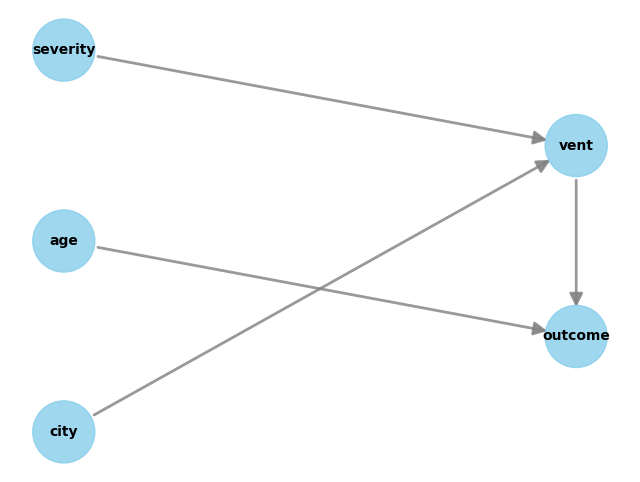

In [84]:
model = dowhy.CausalModel(data=df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="vent",
                          outcome="outcome")
model.view_model()